In [3]:
#Import Libraries
# ----------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set plot style
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-pastel')

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# CELL 2: Load Datasets
# ----------------------------------------------------------------------
# Load all the necessary csv files into pandas dataframes
try:
    customers = pd.read_csv('./data/olist_customers_dataset.csv')
    orders = pd.read_csv('./data/olist_orders_dataset.csv')
    order_items = pd.read_csv('./data/olist_order_items_dataset.csv')
    payments = pd.read_csv('./data/olist_order_payments_dataset.csv')
    products = pd.read_csv('./data/olist_products_dataset.csv')
    sellers = pd.read_csv('./data/olist_sellers_dataset.csv')
    translation = pd.read_csv('./data/product_category_name_translation.csv')
    
    print("All datasets loaded successfully!")
    print("\nSample of customers data:")
    display(customers.head(2))
    print("\nSample of orders data:")
    display(orders.head(2))

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure your data files are in a 'data' subfolder relative to the notebook.")



All datasets loaded successfully!

Sample of customers data:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP



Sample of orders data:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [5]:
# CELL 3: Data Merging & Cleaning
# ----------------------------------------------------------------------
# Merge the datasets into a single dataframe
# Start with orders and customers
df = pd.merge(orders, customers, on='customer_id')

# Add order items
df = pd.merge(df, order_items, on='order_id')

# Add payment information
df = pd.merge(df, payments, on='order_id')

# Add product information
df = pd.merge(df, products, on='product_id')

# Add sellers information
df = pd.merge(df, sellers, on='seller_id')

# Clean up column names by removing prefixes
df.columns = df.columns.str.replace('olist_', '').str.replace('_dataset', '')

print("Datasets merged successfully.")
print(f"Shape of merged dataframe: {df.shape}")

# Convert date columns to datetime objects
date_cols = ['order_purchase_timestamp', 'order_approved_at', 
             'order_delivered_carrier_date', 'order_delivered_customer_date', 
             'order_estimated_delivery_date', 'shipping_limit_date']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing values
# For this analysis, we'll focus on delivered orders, which resolves many NaN issues
df = df[df['order_status'] == 'delivered'].copy()
df.dropna(subset=['order_delivered_customer_date'], inplace=True) # Drop rows where delivery date is still null

print("\nData cleaned and datetime columns converted.")
print(f"Shape after filtering for 'delivered' orders: {df.shape}")
print(f"Remaining null values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")


Datasets merged successfully.
Shape of merged dataframe: (117601, 33)

Data cleaned and datetime columns converted.
Shape after filtering for 'delivered' orders: (115027, 33)
Remaining null values:
order_approved_at                 15
order_delivered_carrier_date       1
product_category_name           1628
product_name_lenght             1628
product_description_lenght      1628
product_photos_qty              1628
product_weight_g                  20
product_length_cm                 20
product_height_cm                 20
product_width_cm                  20
dtype: int64


In [7]:
# CELL 4: Feature Engineering (Defining Churn)
# ----------------------------------------------------------------------
# We will define churn based on customer purchase recency.
# First, let's find the most recent purchase date in the dataset to use as a reference point.
latest_purchase_date = df['order_purchase_timestamp'].max()
print(f"Latest purchase date in dataset: {latest_purchase_date.date()}")

# Define a "current date" for analysis (e.g., one day after the last order)
current_date = latest_purchase_date + pd.Timedelta(days=1)

# Group by customer to create RFM (Recency, Frequency, Monetary) features
customer_df = df.groupby('customer_unique_id').agg(
    recency=('order_purchase_timestamp', lambda date: (current_date - date.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('payment_value', 'sum')
).reset_index()

# Define Churn: A customer is considered "churned" if they haven't purchased in the last 180 days.
churn_threshold_days = 180
customer_df['churn'] = (customer_df['recency'] > churn_threshold_days).astype(int)

print(f"\nCreated RFM features and defined churn (no purchase in last {churn_threshold_days} days).")
print("\nSample of customer RFM data:")
display(customer_df.head())


# ----------------------------------------------------------------------


Latest purchase date in dataset: 2018-08-29

Created RFM features and defined churn (no purchase in last 180 days).

Sample of customer RFM data:


,customer_unique_id,recency,frequency,monetary,churn
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,0
2,0000f46a3911fa3c0805444483337064,537,1,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,1


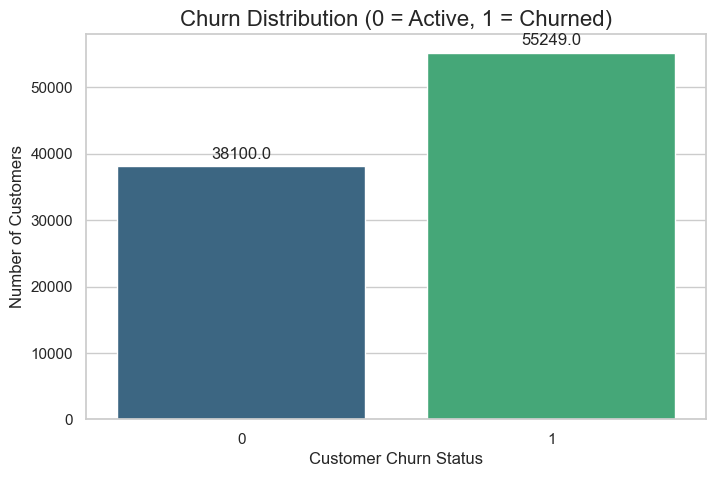

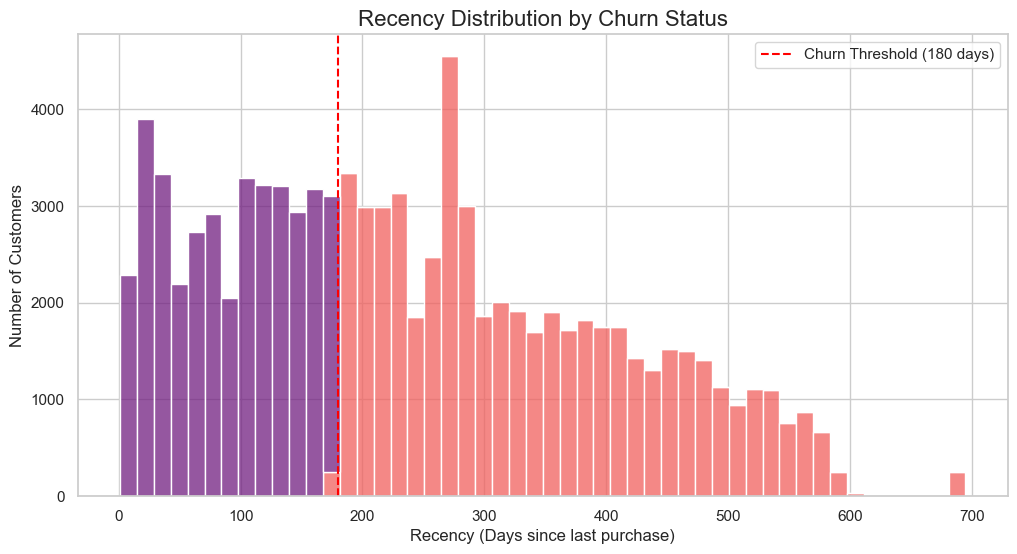

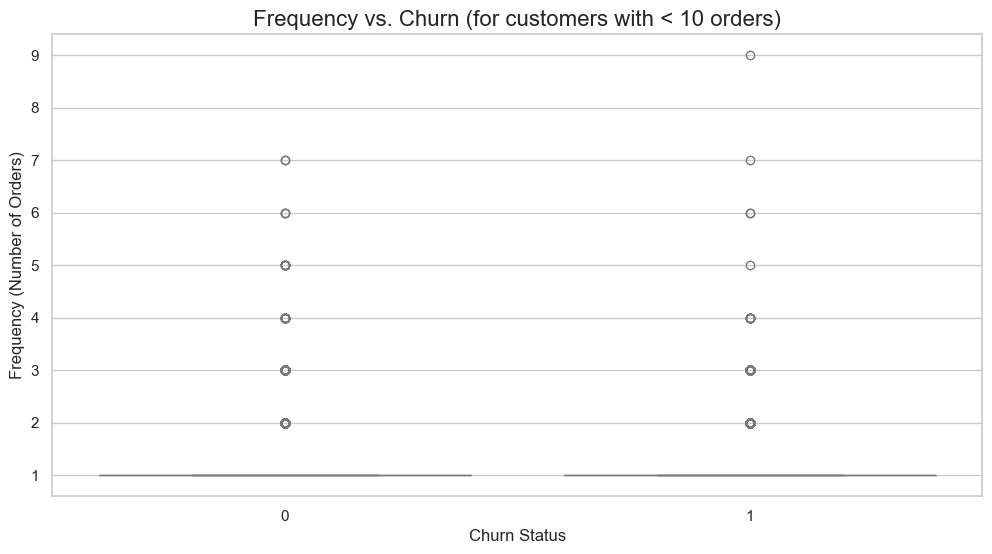

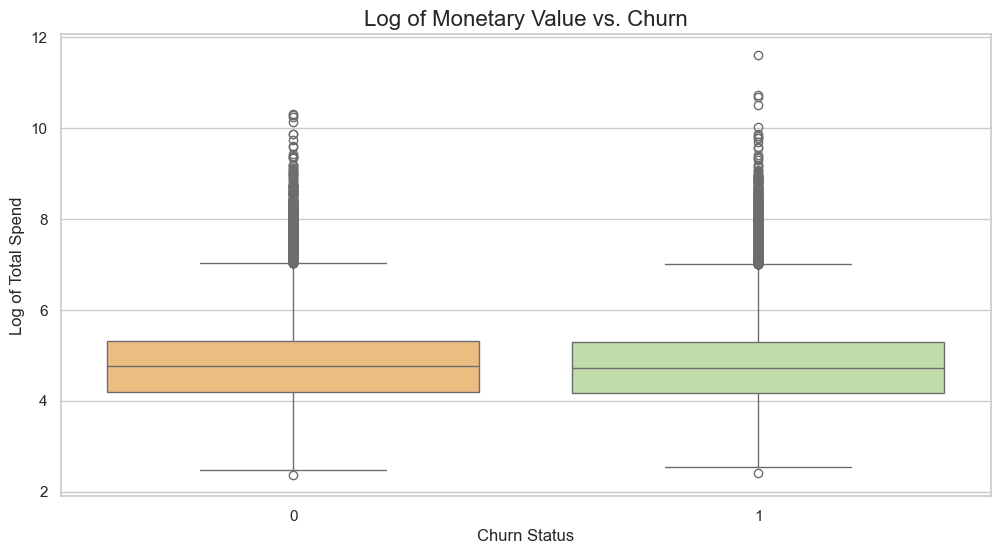

In [11]:
# ----------------------------------------------------------------------
# CELL 5: Exploratory Data Analysis (EDA)
# ----------------------------------------------------------------------
# Churn Distribution
plt.figure(figsize=(8, 5))
# FIX: Added hue='churn' and legend=False
churn_plot = sns.countplot(x='churn', data=customer_df, palette='viridis', hue='churn', legend=False)
plt.title('Churn Distribution (0 = Active, 1 = Churned)', fontsize=16)
plt.xlabel('Customer Churn Status')
plt.ylabel('Number of Customers')
for p in churn_plot.patches:
    churn_plot.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.show()

# Recency vs. Churn
plt.figure(figsize=(12, 6))
sns.histplot(data=customer_df, x='recency', hue='churn', multiple='stack', bins=50, palette='magma')
plt.title('Recency Distribution by Churn Status', fontsize=16)
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Number of Customers')
plt.axvline(churn_threshold_days, color='red', linestyle='--', label=f'Churn Threshold ({churn_threshold_days} days)')
plt.legend()
plt.show()

# Frequency vs. Churn (for customers with < 10 orders)
plt.figure(figsize=(12, 6))
# FIX: Added hue='churn' and legend=False
sns.boxplot(x='churn', y='frequency', data=customer_df[customer_df['frequency'] < 10], palette='coolwarm', hue='churn', legend=False)
plt.title('Frequency vs. Churn (for customers with < 10 orders)', fontsize=16)
plt.xlabel('Churn Status')
plt.ylabel('Frequency (Number of Orders)')
plt.show()

# Monetary vs. Churn
plt.figure(figsize=(12, 6))
# Using log scale for better visualization due to outliers
customer_df['monetary_log'] = np.log1p(customer_df['monetary'])
# FIX: Added hue='churn' and legend=False
sns.boxplot(x='churn', y='monetary_log', data=customer_df, palette='Spectral', hue='churn', legend=False)
plt.title('Log of Monetary Value vs. Churn', fontsize=16)
plt.xlabel('Churn Status')
plt.ylabel('Log of Total Spend')
plt.show()

In [12]:
# CELL 6: Model Preparation
# ----------------------------------------------------------------------
# Select features and target
features = ['recency', 'frequency', 'monetary']
target = 'churn'

X = customer_df[features]
y = customer_df[target]

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split into training and testing sets and scaled.")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")


Data split into training and testing sets and scaled.
X_train shape: (74679, 3)
X_test shape: (18670, 3)


In [13]:
# CELL 7: Model Training (Logistic Regression)
# ----------------------------------------------------------------------
# Initialize and train the model
log_reg = LogisticRegression(random_state=42, class_weight='balanced') # 'balanced' helps with imbalanced classes
log_reg.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7620
           1       1.00      1.00      1.00     11050

    accuracy                           1.00     18670
   macro avg       1.00      1.00      1.00     18670
weighted avg       1.00      1.00      1.00     18670


--- Confusion Matrix ---


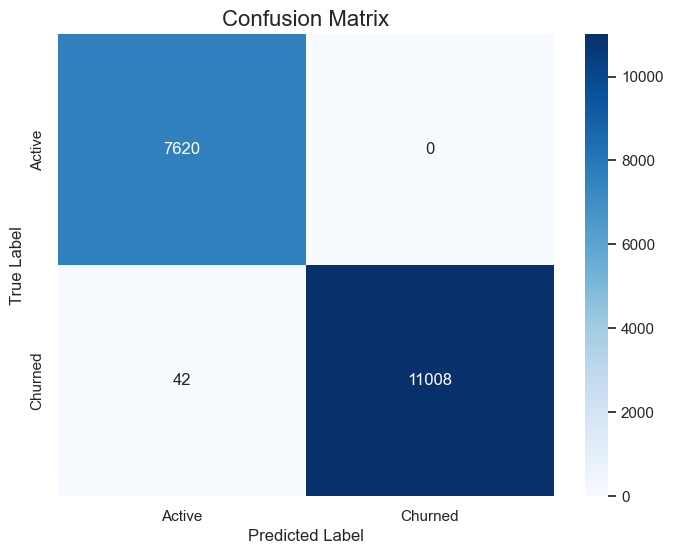


--- ROC-AUC Score ---
The ROC-AUC score is: 1.0000


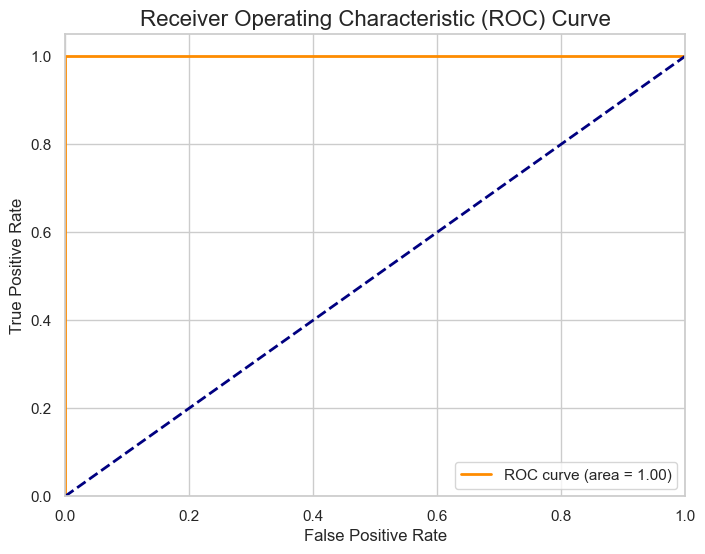

In [14]:
# CELL 8: Model Evaluation
# ----------------------------------------------------------------------
# Make predictions on the test set
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# 1. Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. ROC-AUC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n--- ROC-AUC Score ---")
print(f"The ROC-AUC score is: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()



In [15]:
# CELL 9: Conclusion
# ----------------------------------------------------------------------
# Feature importance (coefficients from logistic regression)
feature_importance = pd.DataFrame(features, columns=['Feature'])
feature_importance['Importance'] = log_reg.coef_[0]
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("--- Feature Importance ---")
display(feature_importance)

print("\nModel successfully built and evaluated. The most important factor for predicting churn is recency.")
print("Next steps could include trying more complex models (like RandomForest or XGBoost) or engineering more features.")








--- Feature Importance ---


,Feature,Importance
0,recency,35.931220
1,frequency,0.004249
2,monetary,-0.011944



Model successfully built and evaluated. The most important factor for predicting churn is recency.
Next steps could include trying more complex models (like RandomForest or XGBoost) or engineering more features.
